#### TODO:
- Algo seems to only be off by $100, but that's not much in the crypto world.
- Need to figure out how to make this more useful. 
- Next price point isn't bad, but what's the start? I can make a decent model. Now what?
    - Figure out how to generate the same data, but now estimate it for the next day.

# Use lagged values to predict current price to forecast price
- Notes from this video: https://www.youtube.com/watch?v=xaIA83x5Icg
 - Create separate transformers for features on different scales
 - Use this video for building an initial LSTM model
- Use this video and it's subsequent one for time series forecasting for BTC using binance exchange data: https://www.youtube.com/watch?v=jR0phoeXjrc
    - Use shift to push a column down for matching previous data points to a forecasted point.
    - This video is showing how to prep data for a time series model.
    - This video is for how to take that preprocessed data and put into PyTorch for the LSTM model: https://www.youtube.com/watch?v=ODEGJ_kh2aA&t=107s
         - 

### TODO:
- Now, it shows a broad trend, but there's just nothing going on? Both indicate a lull right now. 
- Need to pull in the hourly data, to show if there's more variation.

Use Yahoo Finance for this file

In [936]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import os

In [937]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

In [938]:
import datetime

In [939]:
import tensorflow as tf
from keras import layers

In [940]:
from keras import models

In [941]:
from keras import optimizers

In [942]:
import tqdm

In [943]:
def train_models(df, label,training_cols, time_steps):
    scaler = StandardScaler()
    scaler.fit(df[[label]])
    for col in training_cols:
        df[col] = scaler.transform(df[[col]])
    X = df[training_cols].values
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False, random_state=1)
    output = compare_rg(X_train, y_train, X_test, y_test, time_steps)
    return output, scaler

In [944]:
def compare_rg(X_train, y_train, X_test, y_test, time_steps):
    classifiers = {
#         'XGBR': XGBRegressor(),
        'NN': neural_net(X_train.shape, time_steps)
    }

    outputs = {
#         'XGBR': [],
        'NN': []
    }
    for model in classifiers:
        if model == 'NN':            
            algo = classifiers[model]
            X_train, y_train = create_dataset(X_train, y_train, time_steps)
            X_test, y_test = create_dataset(X_test, y_test, time_steps)
            algo.fit(X_train, y_train, X_test, y_test)
        else:
            algo = classifiers[model]
            algo.fit(X_train, y_train)
            y_predict = algo.predict(X_test)
#             print(" ")
#             print(model, ': ',mse(y_test, y_predict))
        for output in outputs:
            if output == model:
                outputs[output] = algo
#         print('')
    return outputs

In [945]:
#https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/
# https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
class neural_net:
    def __init__(self, shape_input, time_steps):
        self.shape_input = shape_input
        self.model = models.Sequential()
        self.batch_size = 32
        self.model.add(layers.LSTM(units=50, input_shape=(time_steps, shape_input[1]), return_sequences=False))
#         self.model.add(layers.Dropout(0.5, name='dropout_0'))
#         self.model.add(layers.Dense(15, activation='relu'))
#         self.model.add(layers.Dropout(0.5, name='dropout_1'))
        self.model.add(layers.Dense(1, activation='relu'))
        self.model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    def fit(self, X_train, y_train, X_test, y_test):
#         for val in y_train:
#             print(val)
        self.model.fit(x=X_train, y=y_train, batch_size = self.batch_size, epochs=50, shuffle=False, validation_split=0.1, verbose=0)
        evaluation = self.model.evaluate(X_test, y_test)
        print(evaluation)
        print(self.model.summary())
    
    def predict(self, Xnew):
        yNew = self.model.predict(Xnew)
        return yNew

In [946]:
def create_dataset(X, y, time_steps = 20):
    y = y.values
    Xs, ys = [] , []
    for i in range(len(X) - time_steps):
        v = X[i: (i+time_steps)]
#         print(np.mean(v))
#         print(y[(i+time_steps)])
#         print('')
        Xs.append(v)
        ys.append(y[(i+time_steps)])
    Xs = np.array(Xs)
    ys = np.array(ys)
    return Xs, ys

In [947]:
future_estim_START = 6
future_estim_STOP = 6

NUM_MODELS = 1

window_size = 20

graph_timespan = 20

MODEL_TYPE = 'NN'

In [948]:
crypto = pd.read_csv('ETH-USD.csv')

In [949]:
for col in crypto.columns.values:
    crypto.rename(columns={
        col: col.lower()
    }, inplace=True)
    
ma = []
upper = []
lower = []
for i in range(window_size):
    ma.append(np.nan)
    upper.append(np.nan)
    lower.append(np.nan)
for row in crypto.iterrows():
    if row[0] < window_size:
        continue
#     print(row[0])
    mean = np.mean(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    ma.append(mean)
    std = np.std(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    upper.append((mean+std*2))
    lower.append((mean-std*2)) 

crypto['ma20'] = ma
crypto['upper'] = upper
crypto['lower'] = lower

training_cols = []
for col in crypto.columns.values:
    if 'next' not in col and 'date' not in col and 'adj' not in col and 'volume' not in col:
        training_cols.append(col)

crypto.drop('adj close',axis=1, inplace=True)

In [950]:
og_crypto = crypto.copy()

### TODO:
- figure out issue with scaling.
- Maybe just scrap this work on ARIMA model

In [951]:
future_estimations = {}
for future_estim in tqdm.trange(future_estim_START, future_estim_STOP+1):
    
#     print('Future Estim: ', str(future_estim))
    
    output_label = 'next_close_'+str(future_estim)

    crypto[output_label] = crypto['close'].shift(-1*future_estim)

    temp_og_crypto = crypto.copy()
    
    trained_models = []
    for i in range(NUM_MODELS):
        crypto = temp_og_crypto.copy()
        crypto = crypto.dropna()
        output, scaler = train_models(crypto, output_label,training_cols, future_estim)
        trained_models.append(output[MODEL_TYPE])

    crypto = og_crypto.copy()

    predict_cols = []
    for i in range(NUM_MODELS):
        col_name = 'predicted_close_'+str(i)
        if MODEL_TYPE == 'NN':
            y = crypto['date']
            X_input, y_input = create_dataset(crypto[training_cols].values, y, future_estim)
            result = trained_models[i].predict(X_input)
            results = result.tolist()
            to_append = []
            for result in results:
                to_append.append(result[0])
            while len(to_append) < crypto.shape[0]:
                to_append.append(np.nan)
            crypto[col_name] = to_append
            print(crypto[col_name].value_counts(normalize='true'))
            predict_cols.append(col_name)
        else:
            crypto[col_name] = trained_models[i].predict(crypto[training_cols].values)
            predict_cols.append(col_name)

#     future_estimations.update({'predicted_close_'+str(future_estim) : crypto[})
    
    for col in temp_og_crypto.columns.values:
        og_crypto[col] = temp_og_crypto[col]
#     print('Cols:', og_crypto.columns.values)
#     print(og_crypto.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 2ms/step - loss: 4926668.5000
4926668.5
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 50)                11600     
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
None


100%|██████████| 1/1 [00:17<00:00, 17.97s/it]

<class 'list'>
nan
nan
68.701004    0.696919
68.700996    0.028011
68.700981    0.011765
68.700966    0.010084
68.700989    0.005602
               ...   
14.179602    0.000560
68.686943    0.000560
65.937599    0.000560
68.700386    0.000560
15.018339    0.000560
Name: predicted_close_0, Length: 373, dtype: float64


In [952]:
crypto

,date,open,high,low,close,volume,ma20,upper,lower,predicted_close_0
0,2016-07-18,11.173000,11.610100,10.948300,11.034400,1.593190e+07,NaN,NaN,NaN,NaN
1,2016-07-19,11.046600,12.013900,11.010300,11.619100,2.173000e+07,NaN,NaN,NaN,NaN
2,2016-07-20,11.590200,12.991400,11.566900,12.450600,6.022610e+07,NaN,NaN,NaN,NaN
3,2016-07-21,12.460100,12.710300,11.993700,12.650700,2.463690e+07,NaN,NaN,NaN,NaN
4,2016-07-22,12.657500,14.813400,12.539900,14.661900,7.477950e+07,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1822,2021-07-14,1941.167847,2015.107422,1869.223145,1994.331299,1.734282e+10,2113.464050,2403.885647,1823.042454,NaN
1823,2021-07-15,1994.712036,2037.742554,1883.272217,1911.175659,1.568809e+10,2113.757800,2403.684504,1823.831097,NaN
1824,2021-07-16,1916.598389,1959.696289,1853.590332,1880.382935,1.488457e+10,2118.655719,2390.877172,1846.434266,NaN
1825,2021-07-17,1876.881348,1917.597900,1855.590820,1898.825195,1.336428e+10,2121.212903,2383.283063,1859.142742,NaN


In [953]:
dates = []
for date in crypto['date']:
    if not isinstance(date, str):
        if date is np.nan:
            prev_date += datetime.timedelta(days=1)
            dates.append(prev_date)
        else:
            dates.append(date)
            prev_date = date
    else:
        if date is np.nan:
            prev_date += datetime.timedelta(days=1)
            dates.append(prev_date)
        else:
            date_list = date.split('-')
            date = datetime.datetime(year=int(date_list[0]), month=int(date_list[1]), day=int(date_list[2]))
            dates.append(date)
            prev_date = date

In [954]:
crypto['date'] = dates

In [955]:
crypto.dropna(subset=['date'], inplace=True)

In [956]:
for estim in future_estimations:
    crypto[estim] = future_estimations[estim]

In [957]:
future_estimations

{}

In [958]:
crypto

,date,open,high,low,close,volume,ma20,upper,lower,predicted_close_0
0,2016-07-18,11.173000,11.610100,10.948300,11.034400,1.593190e+07,NaN,NaN,NaN,NaN
1,2016-07-19,11.046600,12.013900,11.010300,11.619100,2.173000e+07,NaN,NaN,NaN,NaN
2,2016-07-20,11.590200,12.991400,11.566900,12.450600,6.022610e+07,NaN,NaN,NaN,NaN
3,2016-07-21,12.460100,12.710300,11.993700,12.650700,2.463690e+07,NaN,NaN,NaN,NaN
4,2016-07-22,12.657500,14.813400,12.539900,14.661900,7.477950e+07,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1822,2021-07-14,1941.167847,2015.107422,1869.223145,1994.331299,1.734282e+10,2113.464050,2403.885647,1823.042454,NaN
1823,2021-07-15,1994.712036,2037.742554,1883.272217,1911.175659,1.568809e+10,2113.757800,2403.684504,1823.831097,NaN
1824,2021-07-16,1916.598389,1959.696289,1853.590332,1880.382935,1.488457e+10,2118.655719,2390.877172,1846.434266,NaN
1825,2021-07-17,1876.881348,1917.597900,1855.590820,1898.825195,1.336428e+10,2121.212903,2383.283063,1859.142742,NaN


In [959]:
next_cols = []
for col in crypto.columns.values:
    if 'next' in col:
        next_cols.append(col)

In [960]:
for col in next_cols:
    future_estim = int(col.split('_')[-1])
    crypto['next_close_'+str(future_estim)] = crypto['next_close_'+str(future_estim)].shift(future_estim)
    crypto['predicted_close_'+str(future_estim)] = crypto['predicted_close_'+str(future_estim)].shift(future_estim)

In [961]:
predict_cols = []
for col in crypto.columns.values:
    if 'predicted' in col:
        predict_cols.append(col)

In [962]:
crypto = crypto.tail(graph_timespan)

In [963]:
plot_estims = {}
for col in predict_cols:
    plot_estims.update({col: crypto[col].tolist()})

In [964]:
y_true = crypto['close'].tolist()
y_ma = crypto['ma20'].tolist()
y_upper = crypto['upper'].tolist()
y_lower = crypto['lower'].tolist()
x = crypto['date'].tolist()

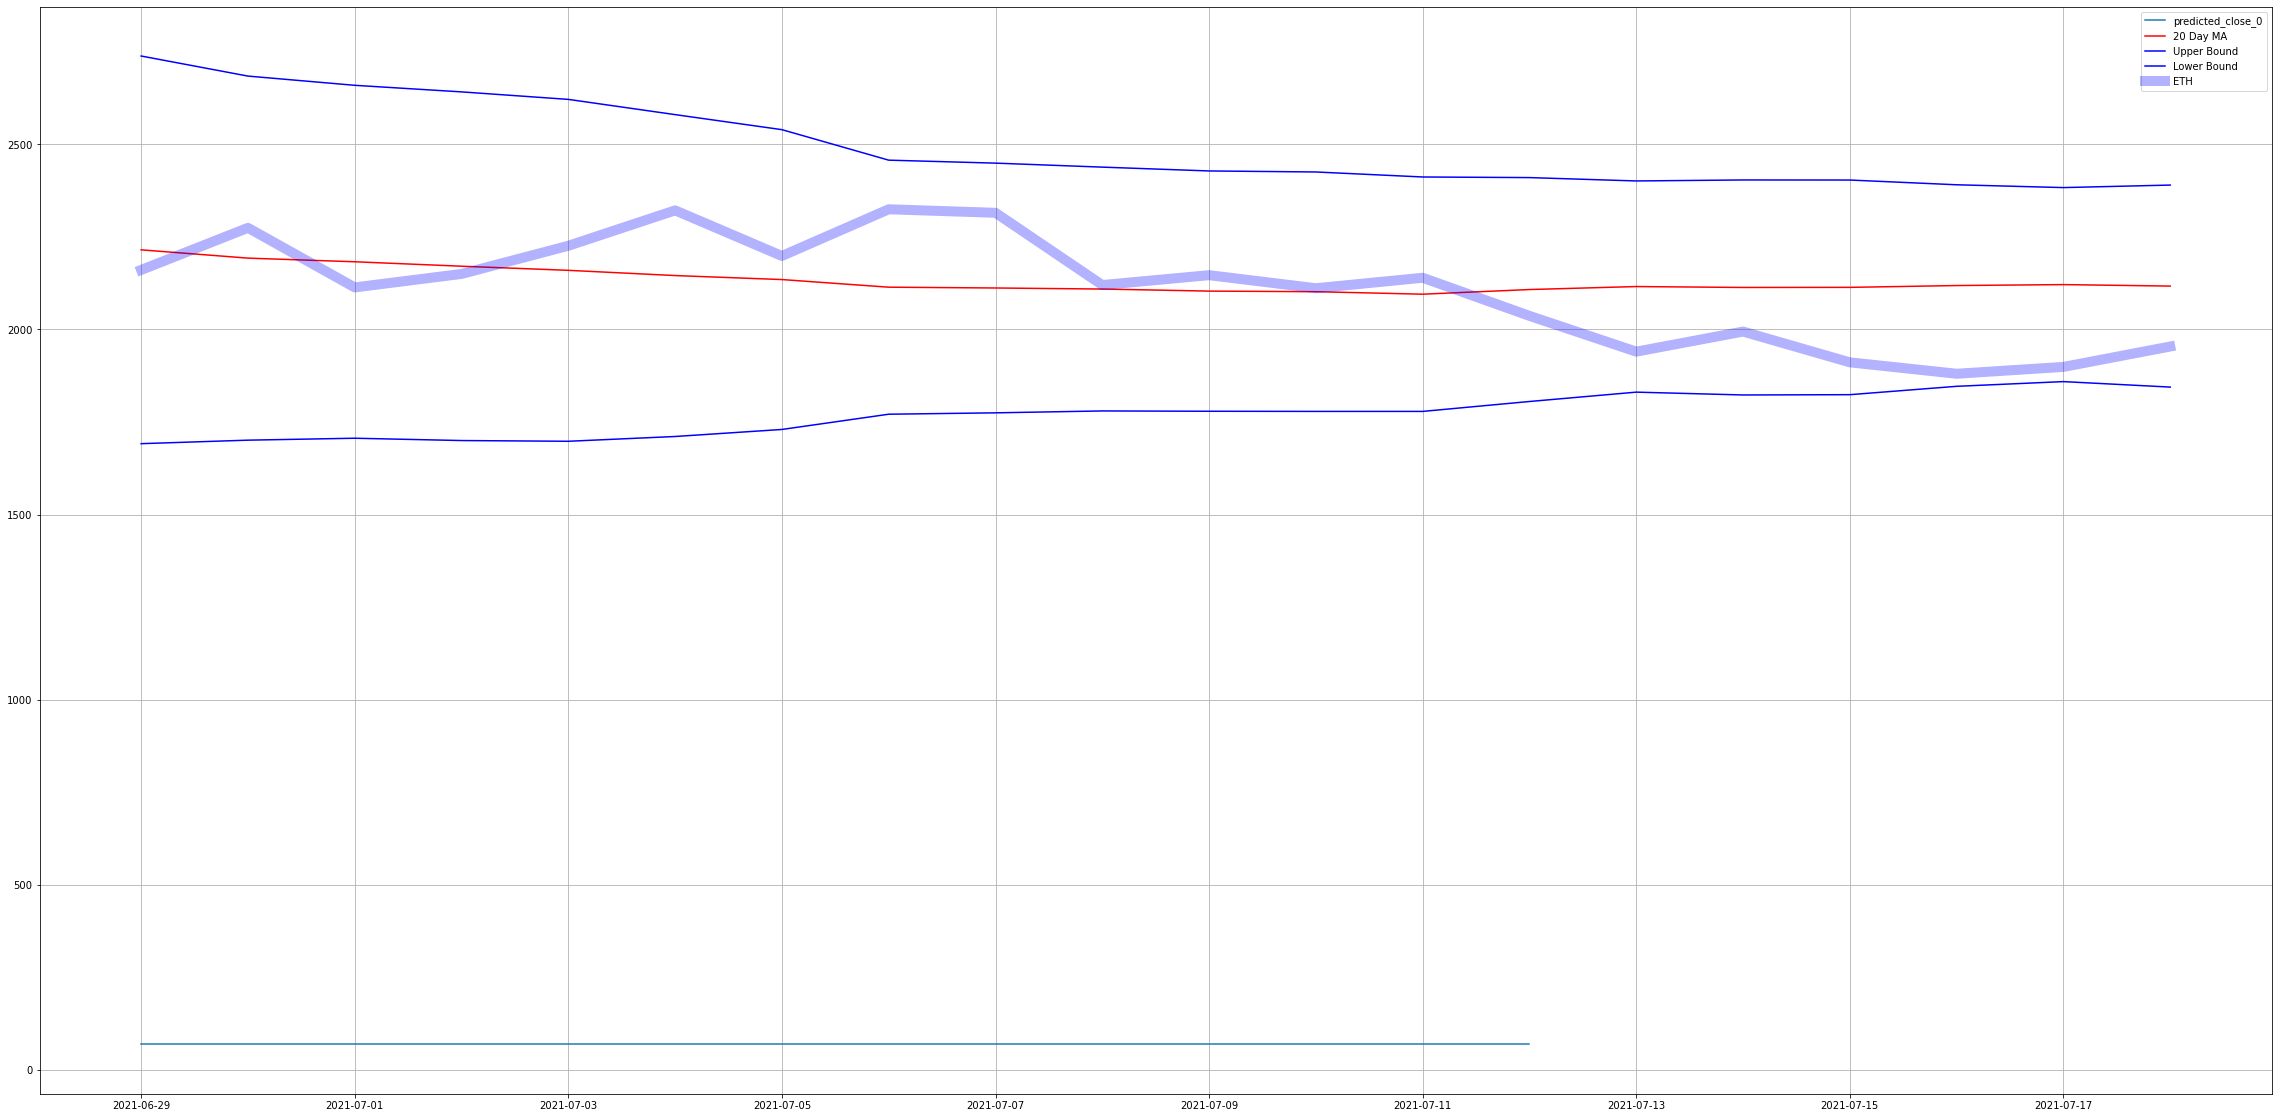

In [965]:
fig = plt.figure(figsize=(40,20))
for estim in plot_estims:
    plt.plot(x, plot_estims[estim], label=estim)
plt.plot(x, y_ma, label='20 Day MA', color='r')
plt.plot(x, y_upper, label='Upper Bound', color='b')
plt.plot(x, y_lower, label='Lower Bound', color='b')
plt.plot(x, y_true, label='ETH', linewidth=10, color='b', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

In [966]:
crypto[predict_cols].tail()

,predicted_close_0
1822,NaN
1823,NaN
1824,NaN
1825,NaN
1826,NaN


In [967]:
# crypto.to_excel('ETH-USD_forecast_from_'+str(datetime.datetime.today()).split(' ')[0]+'.xlsx')